### Overview

This notebook creates a NN following Toms et al. 
It expands on Toms et al. to predict El Nino or La Nina at a specified lead time using SST anomalies only in the extratropics and applies LRP to determine the input that contributed to the prediction.  

Data are 1948-2014 (can extend to 2019 later)
Train: 1948-2001 (54)
Test: 2002-2014 (13)

### Imports

In [1]:
import xarray as xr
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as colors

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import warnings
warnings.filterwarnings("ignore")

In [2]:
enso_index='ep'
nmon=9

### Read Data

In [3]:
path='/homes/kpegion/projects/etenso/obs/rmensoepcp/data/obs/'
fname_sst='sst.ERSST.anom.detrend.globalreg.1948-2014.gr.noepcp.nc'
ds_sst = xr.open_dataset(path+fname_sst,decode_times=False)
ds_sst['time']=pd.date_range(start='1948-01', end='2014-12',freq='MS')
ds_sst['anom']=xr.where(ds_sst['anom']>=9.90e8,0.0,ds_sst['anom'])
ds_sst=ds_sst.fillna(0)
ds_sst

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 181, time: 804)
Coordinates:
  * lat      (lat) float64 -88.0 -86.0 -84.0 -82.0 -80.0 ... 82.0 84.0 86.0 88.0
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0 360.0
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2014-12-01
Data variables:
    anom     (time, lat, lon) float64 0.0 0.0 0.0 ... -1.104e-05 -1.104e-05 0.0
Attributes:
    title:         RMENSO
    long_title:    RMENSO
    comments:      none
    institution:   GMU/COLA
    source:        
    CreationDate:  2020/01/15 15:17:55
    CreatedBy:     kpegion
    MatlabSource:  regressoutENSOglobal

In [4]:
fname_slp='slp.NCEPR1.anom.detrend.globalreg.1948-2014.gr.noepcp.nc'
ds_slp = xr.open_dataset(path+fname_slp,decode_times=False)
ds_slp['time']=pd.date_range(start='1948-01', end='2014-12',freq='MS')
ds_slp['anom']=xr.where(ds_slp['anom']>=9.90e8,0.0,ds_slp['anom'])
ds_slp=ds_slp.fillna(0)
ds_slp

<xarray.Dataset>
Dimensions:  (lat: 73, lon: 144, time: 804)
Coordinates:
  * lat      (lat) float64 -90.0 -87.5 -85.0 -82.5 -80.0 ... 82.5 85.0 87.5 90.0
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2014-12-01
Data variables:
    anom     (time, lat, lon) float64 -9.067 -9.067 -9.067 ... 2.598 2.598 2.598
Attributes:
    title:         RMENSO
    long_title:    RMENSO
    comments:      none
    institution:   GMU/COLA
    source:        
    CreationDate:  2020/01/15 15:00:09
    CreatedBy:     kpegion
    MatlabSource:  regressoutENSOglobal

### Get output variables (CP & EP)

In [5]:
path_enso='/homes/kpegion/projects/etenso/obs/rmensoepcp/data/analysis/enso/'
file_enso='cpep.ERSST.pc.nc' 

In [6]:
ds_enso = xr.open_dataset(path_enso+file_enso,decode_times=False).squeeze()
ds_enso['time']=ds_sst['time']
ds_enso

<xarray.Dataset>
Dimensions:  (time: 804)
Coordinates:
    lat      float64 0.0
    lon      float64 0.0
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2014-12-01
Data variables:
    ep       (time) float64 ...
    cp       (time) float64 ...
Attributes:
    title:         EP CP ENSO
    long_title:    EP and CP PC timeseries
    comments:      
    institution:   GMU/COLA
    source:        ERSST/NCEPR1
    CreationDate:  2018/11/25 18:39:01
    CreatedBy:     kpegion
    MatlabSource:  /homes/kpegion/projects/etenso/obs/rmenso/src/calcEPCPENSO.m

### Split Train and Test

In [7]:
# Get the years for the Predictors (aka Features)
sst_anom_train=ds_sst.sel(time=slice('1948-01','2001-12'))
sst_anom_test=ds_sst.sel(time=slice('2002-01','2014-12'))
slp_anom_train=ds_slp.sel(time=slice('1948-01','2001-12'))
slp_anom_test=ds_slp.sel(time=slice('2002-01','2014-12'))

# Extract only El Nino and La Nina Events
sst_anom_train=sst_anom_train['anom'][0:len(sst_anom_train['time']),:,:].where(np.abs(ds_enso[enso_index])>0.5).dropna(dim='time',how='all')
sst_anom_test=sst_anom_test['anom'][0:len(sst_anom_train['time']),:,:].where(np.abs(ds_enso[enso_index])>0.5).dropna(dim='time',how='all')
slp_anom_train=slp_anom_train['anom'][0:len(slp_anom_train['time']),:,:].where(np.abs(ds_enso[enso_index])>0.5).dropna(dim='time',how='all')
slp_anom_test=slp_anom_test['anom'][0:len(slp_anom_train['time']),:,:].where(np.abs(ds_enso[enso_index])>0.5).dropna(dim='time',how='all')


# Get the years for the Predictand
nino_train=ds_enso.sel(time=slice('1948-01','2001-12'))
nino_test=ds_enso.sel(time=slice('2002-01','2014-12'))

# Select only El Nino and La nina Events
nino_train=nino_train[enso_index].where(np.abs(ds_enso[enso_index])>0.5).dropna(dim='time',how='all')
nino_test=nino_test[enso_index].where(np.abs(ds_enso[enso_index])>0.5).dropna(dim='time',how='all')

### Get dimensions for use later

In [8]:
nx_sst=len(ds_sst['lon'])
ny_sst=len(ds_sst['lat'])
nx_slp=len(ds_slp['lon'])
ny_slp=len(ds_slp['lat'])
nt=len(ds_sst['time'])
print(nx_sst,ny_sst,nx_slp,ny_slp,nt)

181 89 144 73 804


### Turn into categorization problem with 1's and 0's for warm and cold events

In [9]:
# Predictors ( aka Features ): Training on first nt_train months 
X1_train=sst_anom_train.values
X2_train=slp_anom_train.values


# Create output vector based as a Categorical Predictand El Nino = [True,False] and La Nina = [False,True]
l_warm_train = ( nino_train > 0.5 )
l_cold_train = ( nino_train < -0.5 )
y_train = np.array([l_warm_train,l_cold_train]).T

# Get dimensions of training data
nt_train,junk=y_train.shape
y_train.shape

(380, 2)

### Set Y for prediction problem

In [10]:
y_train=y_train[nmon:nt_train,:]
X1_train=X1_train[0:nt_train-nmon,:,:]
X2_train=X2_train[0:nt_train-nmon,:,:]
nt_train=nt_train-nmon
inputdim=nx_sst*ny_sst+nx_slp*ny_slp

In [11]:
print(X1_train.shape,X2_train.shape,y_train.shape, nt_train)

(371, 89, 181) (371, 73, 144) (371, 2) 371


In [12]:
print("El Nino TRAIN: ",l_warm_train[l_warm_train==True].count().values)
print("La Nina TRAIN: ",l_cold_train[l_cold_train==True].count().values)

El Nino TRAIN:  162
La Nina TRAIN:  218


### Make a keras model

In [13]:
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
from keras import initializers
from keras import optimizers

Using TensorFlow backend.


In [14]:
model = Sequential()

model.add(Dense(8, input_dim=inputdim,activation='relu',
                kernel_initializer='he_normal',
                kernel_regularizer=regularizers.l2(25),
                bias_initializer='he_normal'))

model.add(Dense(8, activation='relu',
                kernel_initializer='he_normal',
                bias_initializer='he_normal',
                kernel_regularizer=regularizers.l2(0.01)))

model.add(Dense(2, activation='softmax'))

model.compile(loss='binary_crossentropy', 
              metrics=['accuracy'],
              optimizer=optimizers.SGD(lr=0.001,nesterov=True,momentum=0.9))







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Train the NN

In [15]:
X1_tmp=X1_train.reshape(nt_train,nx_sst*ny_sst)
X2_tmp=X2_train.reshape(nt_train,nx_slp*ny_slp)
XX=np.hstack([X1_tmp,X2_tmp])
print(XX.shape)

(371, 26621)


In [16]:
#XX = X_train.reshape(nt_train,nx*ny)
model.fit(XX, y_train, epochs=200, batch_size=10)

Epoch 1/200
371/371 [==============================] - 0s 1ms/step - loss: 48.7496 - acc: 0.5229
Epoch 2/200
371/371 [==============================] - 0s 378us/step - loss: 2.1604 - acc: 0.5310
Epoch 3/200
371/371 [==============================] - 0s 365us/step - loss: 1.0195 - acc: 0.5768
Epoch 4/200
371/371 [==============================] - 0s 373us/step - loss: 1.0354 - acc: 0.5660
Epoch 5/200
371/371 [==============================] - 0s 364us/step - loss: 0.9464 - acc: 0.5741
Epoch 6/200
371/371 [==============================] - 0s 389us/step - loss: 0.9404 - acc: 0.5687
Epoch 7/200
371/371 [==============================] - 0s 388us/step - loss: 0.8959 - acc: 0.5795
Epoch 8/200
371/371 [==============================] - 0s 389us/step - loss: 0.9047 - acc: 0.5714
Epoch 9/200
371/371 [==============================] - 0s 384us/step - loss: 0.9650 - acc: 0.5741
Epoch 10/200
371/371 [==============================] - 0s 410us/step - loss: 0.8970 - acc: 0.5795
Epoch 11/200
371/371

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8)                 212976    
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 18        
Total params: 213,066
Trainable params: 213,066
Non-trainable params: 0
_________________________________________________________________


In [18]:
# evaluate the keras model
_, accuracy = model.evaluate(XX, y_train)
print('Training Accuracy: %.2f' % (accuracy*100))

371/371 [==============================] - 0s 278us/step
Training Accuracy: 57.95


### Test the Model Accuracy using Test Data
Need to setup for N-month lead

In [19]:
# Predictors ( aka Features )
#X_test=sst_anom_test.values

# Select El Nino and La Nina (Categorical Predictand)
#l_warm_test = ( nino_test > 0.5 )
#l_cold_test = ( nino_test < -0.5 )
#y_test = np.array([l_warm_test,l_cold_test]).T

#nt_test,junk=y_test.shape

#y_test.shape

In [20]:
#y_test=y_test[nmon:nt_test,:]
#X_test=X_test[0:nt_test-nmon,:,:]
#nt_test=nt_test-nmon

In [21]:
#XX_test = X_test.reshape(nt_test,nx*ny)
#XX_test[np.isnan(XX_test)] = 0.0

In [22]:
#print(XX_test.shape, y_test.shape)

In [23]:
#_, test_accuracy = model.evaluate(XX_test, y_test)
#print('Testing Accuracy: %.2f' % (test_accuracy*100))

### Apply `iNNvestigate` using all El Nino and La Nina Cases as Input

In [24]:
import innvestigate
import innvestigate.utils

In [25]:
# Predictors ( aka Features ): Training on first nt_train months 
X1=ds_sst['anom'].where(np.abs(ds_enso[enso_index])>0.5).dropna(dim='time',how='all').values
X2=ds_slp['anom'].where(np.abs(ds_enso[enso_index])>0.5).dropna(dim='time',how='all').values

nt_new,junk,junk=X1.shape

X1_tmp=X1.reshape(nt_new,nx_sst*ny_sst)
X2_tmp=X2.reshape(nt_new,nx_slp*ny_slp)
X=np.hstack([X1_tmp,X2_tmp])
print(X.shape)


# Select El Nino and La Nina (Categorical Predictand)
y=ds_enso[enso_index].where(np.abs(ds_enso[enso_index])>0.5).dropna(dim='time',how='all')
l_warm = ( y > 0.5 )
l_cold = ( y < -0.5 )
y = np.array([l_warm,l_cold]).T

y.shape

(461, 26621)


(461, 2)

In [26]:
print(X.shape)

(461, 26621)


In [27]:
print("El Nino ALL: ",l_warm[l_warm==True].count().values)
print("La Nina ALL: ",l_cold[l_cold==True].count().values)

El Nino ALL:  195
La Nina ALL:  266


In [28]:
# Strip softmax layer
model = innvestigate.utils.model_wo_softmax(model)

# Create analyzer
analyzer = innvestigate.create_analyzer("deep_taylor", model)

# Apply analyzer w.r.t. maximum activated output-neuron
a = analyzer.analyze(X)

In [29]:
a.shape

(461, 26621)

### Get El Nino Cases, Reshape to `time,lat,lon`

In [30]:
# Get El Nino Cases
a_warm=a[l_warm==True,:]

# Reshape to time,lat,lon
tmp=a_warm.shape

# Find times corresponding to El Nino
ds_time=ds_sst['anom'][0:nt,:,:].where(np.abs(ds_enso[enso_index])>0.5).dropna(dim='time',how='all')['time'][l_warm==True]

In [31]:
a=a_warm.reshape((tmp[0],nx_sst*ny_sst+nx_slp*ny_slp))
a_sst=a[:,0:nx_sst*ny_sst].reshape(tmp[0],ny_sst,nx_sst)
a_slp=a[:,nx_sst*ny_sst:].reshape(tmp[0],ny_slp,nx_slp)

### Make `xarray.Dataset`

In [32]:
ds_tmp=xr.DataArray(a_sst,
                    coords={'time':ds_time,
                            'lat':ds_sst['lat'].values,
                            'lon': ds_sst['lon'].values},
                    dims=['time','lat','lon'])        
ds_lrp_sst=ds_tmp.to_dataset(name='warm')
ds_lrp_sst

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 181, time: 195)
Coordinates:
  * time     (time) datetime64[ns] 1948-02-01 1948-03-01 ... 2012-08-01
  * lat      (lat) float64 -88.0 -86.0 -84.0 -82.0 -80.0 ... 82.0 84.0 86.0 88.0
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0 360.0
Data variables:
    warm     (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 -0.0 -0.0 0.0

In [33]:
ds_tmp=xr.DataArray(a_slp,
                    coords={'time':ds_time,
                            'lat':ds_slp['lat'].values,
                            'lon': ds_slp['lon'].values},
                    dims=['time','lat','lon'])        
ds_lrp_slp=ds_tmp.to_dataset(name='warm')
ds_lrp_slp

<xarray.Dataset>
Dimensions:  (lat: 73, lon: 144, time: 195)
Coordinates:
  * time     (time) datetime64[ns] 1948-02-01 1948-03-01 ... 2012-08-01
  * lat      (lat) float64 -90.0 -87.5 -85.0 -82.5 -80.0 ... 82.5 85.0 87.5 90.0
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Data variables:
    warm     (time, lat, lon) float32 -0.0 -0.0 -0.0 -0.0 ... 0.0 0.0 0.0 0.0

### Normalize by max value in grid for each input

In [34]:
ds_lrp_sst=ds_lrp_sst/ds_lrp_sst.max(dim=['lat','lon'])
ds_lrp_slp=ds_lrp_slp/ds_lrp_slp.max(dim=['lat','lon'])
ds_lrp_sst

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 181, time: 195)
Coordinates:
  * time     (time) datetime64[ns] 1948-02-01 1948-03-01 ... 2012-08-01
  * lat      (lat) float64 -88.0 -86.0 -84.0 -82.0 -80.0 ... 82.0 84.0 86.0 88.0
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0 360.0
Data variables:
    warm     (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan

### Plot Composite Relevance for N-month prediction

In [35]:
from cartopy.util import add_cyclic_point

Text(0.5, 0.98, 'All ENSO inputs Lead: 9')

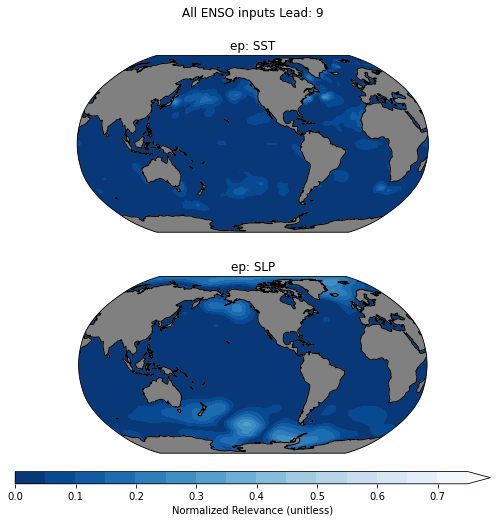

In [36]:
clevs=np.arange(0.0,0.8,.05)

fig, ax = plt.subplots(nrows=2,ncols=1,
                       subplot_kw={'projection': ccrs.Robinson(central_longitude=230)},
                       figsize=(11,8.5))

data, lons = add_cyclic_point(ds_lrp_sst['warm'].mean(dim='time'), 
                              coord=ds_lrp_sst['lon'])
cs=ax[0].contourf(lons, ds_lrp_sst['lat'], data,clevs,
               transform = ccrs.PlateCarree(),cmap='Blues_r',
               extend='max')
ax[0].add_feature(cfeature.NaturalEarthFeature('physical','land', '110m',
                                            edgecolor='gray', facecolor='gray'))
ax[0].coastlines()

ax[0].set_title(enso_index+': SST')

### SLP

data, lons = add_cyclic_point(ds_lrp_slp['warm'].mean(dim='time'), 
                              coord=ds_lrp_slp['lon'])
cs=ax[1].contourf(lons, ds_lrp_slp['lat'], data,clevs,
               transform = ccrs.PlateCarree(),cmap='Blues_r',
               extend='max')
ax[1].add_feature(cfeature.NaturalEarthFeature('physical','land', '110m',
                                            edgecolor='gray', facecolor='gray'))
ax[1].coastlines()

ax[1].set_title(enso_index+': SLP')

# Adjust the location of the subplots 
# on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.95,
                    wspace=0.25, hspace=0.25)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.2, 0.6, 0.02])

# Draw the colorbar
cbar=fig.colorbar(cs, cax=cbar_ax,
                  orientation='horizontal',
                  label='Normalized Relevance (unitless)')
plt.suptitle('All ENSO inputs Lead: '+str(nmon))